<a href="https://colab.research.google.com/github/sujeongzoe/KDT/blob/main/%5BBrain_Tumor%5Dhyperparameter_tuning_lr_0_000001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="min")
- monitor : 관찰하고자 하는 항목으로 'val_loss'나 'val_acc'를 주로 사용
- patience : 개선이 없다고 바로 종료하지 않고 개선이 없는 epoch를 얼마나 기다려 줄 것인가를 지정. 만약 10이라고 하면 개선이 없는 epoch를 10번째 지속될 경우 학습을 종료
-mode : 관찰 항목에 대해 개선이 없다고 판단하기 위한 기준을 지정. 예를 들어, 관찰 항목이 'val_loss'인 경우 감소되는 것이 멈출 때 종료되어야 하므로 'min'으로 설정된다. auto는 관찰하는 이름에 따라 자동으로 지정, min은 관찰하고 있는 항목이 감소되는 것을 멈출 때 종료, max는 관찰하고 있는 항목이 증가되는 것을 멈출 때 종료.

In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style('whitegrid')
import tensorflow as tf
from tensorflow.keras import layers,models,optimizers,preprocessing
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.metrics import AUC

In [ ]:
main_dir = "/content/drive/MyDrive/KDT_project/"
classification_dirs = [("no",), ("yes",)]
resolution = 224

def load_images(root_dir_name):
    x = []
    y = []

    for label, sub_dir_names in enumerate(classification_dirs):
        for sub_dir_name in sub_dir_names:
            print(f"loading {root_dir_name} {sub_dir_name}")
            sub_dir_path = os.path.join(main_dir, root_dir_name, sub_dir_name)
            for image_name in os.listdir(sub_dir_path):
                image_path = os.path.join(sub_dir_path, image_name)
                image = preprocessing.image.load_img(image_path, target_size=(resolution, resolution))   # keras load_img
                x.append(preprocessing.image.img_to_array(image))   # 이미지를 numpy array로 변환
                y.append(label)

    x = np.array(x) / 255.0
    y = np.array(y)

    return x, y

In [ ]:
X_train, y_train = load_images("train/data")
X_test, y_test = load_images("test/data")

loading train/data no
loading train/data yes
loading test/data no
loading test/data yes


In [ ]:
print(X_train.shape, y_train.shape,X_test.shape,y_test.shape)

(1078, 224, 224, 3) (1078,) (231, 224, 224, 3) (231,)


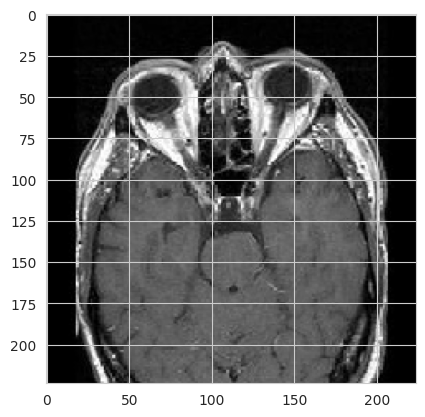

In [ ]:
plt.imshow(X_train[0])

In [ ]:
# Dropout-layer + GAP + Batch-normalization
# 모델 생성 (VGG16)
model_1 = tf.keras.Sequential([

    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224,224,3)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128,(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128,(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.GlobalAveragePooling2D(),   # 피쳐 방향으로 다 더해준다.(flatten 했을 경우 데이터가 너무 많아 오버피팅 되는 것을 방지)
    layers.Flatten(),

    layers.Dense(4069, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(4069, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(1, activation='sigmoid')
])

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 220, 220, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                        

In [ ]:
# 모델 컴파일
lr = 0.000001
model_1.compile(optimizer=tf.keras.optimizers.Adam(lr),
                loss='binary_crossentropy',
                metrics=['accuracy', AUC(name='AUC')])

# 모델 학습
from tensorflow.python.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss", patience=20, mode="min")

history_1 = model_1.fit(X_train, y_train, epochs=150, batch_size=32,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping])

Epoch 1/150
34/34 [==============================] - 55s 791ms/step - loss: 0.6483 - accuracy: 0.6317 - AUC: 0.5272 - val_loss: 0.6914 - val_accuracy: 0.5844 - val_AUC: 0.5000
Epoch 2/150
34/34 [==============================] - 15s 445ms/step - loss: 0.5224 - accuracy: 0.7737 - AUC: 0.6761 - val_loss: 0.6865 - val_accuracy: 0.5844 - val_AUC: 0.4156
Epoch 3/150
34/34 [==============================] - 15s 451ms/step - loss: 0.4741 - accuracy: 0.7829 - AUC: 0.7773 - val_loss: 0.6808 - val_accuracy: 0.5844 - val_AUC: 0.4242
Epoch 4/150
34/34 [==============================] - 15s 453ms/step - loss: 0.4367 - accuracy: 0.7996 - AUC: 0.8304 - val_loss: 0.6803 - val_accuracy: 0.5844 - val_AUC: 0.4574
Epoch 5/150
34/34 [==============================] - 15s 443ms/step - loss: 0.4012 - accuracy: 0.8182 - AUC: 0.8739 - val_loss: 0.6816 - val_accuracy: 0.5844 - val_AUC: 0.4724
Epoch 6/150
34/34 [==============================] - 15s 451ms/step - loss: 0.3690 - accuracy: 0.8516 - AUC: 0.9015 - va

In [ ]:
from sklearn.metrics import roc_curve, auc
y_pred_1 = model_1.predict(X_test)
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_pred_1)
roc_auc_1 = auc(fpr_1, tpr_1)
print('AUROC: ', roc_auc_1)

8/8 [==============================] - 1s 116ms/step
AUROC:  0.9918209876543209


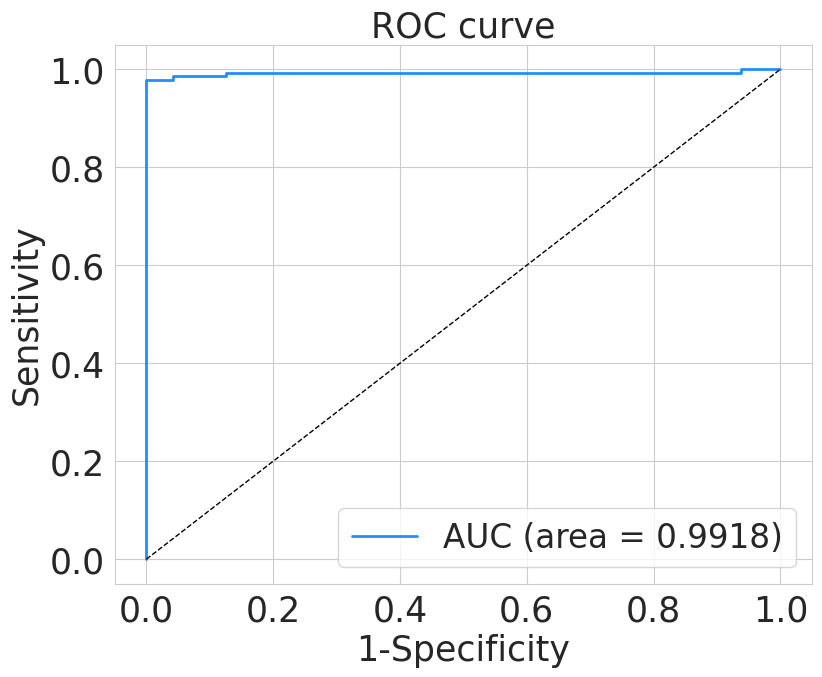

In [ ]:
plt.figure(figsize=[9,7])
plt.plot(fpr_1, tpr_1, color='dodgerblue', lw=2, label='AUC (area = %0.4f)' % roc_auc_1)
plt.plot([0,1], [0,1], color='black', lw=1, linestyle='--')
plt.xlim([-.05, 1.05])
plt.ylim([-.05, 1.05])
plt.xlabel('1-Specificity', fontsize=25)  # FPR
plt.ylabel('Sensitivity', fontsize=25)
plt.title('ROC curve', fontsize=25)
plt.legend(loc='lower right', fontsize=23.5)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

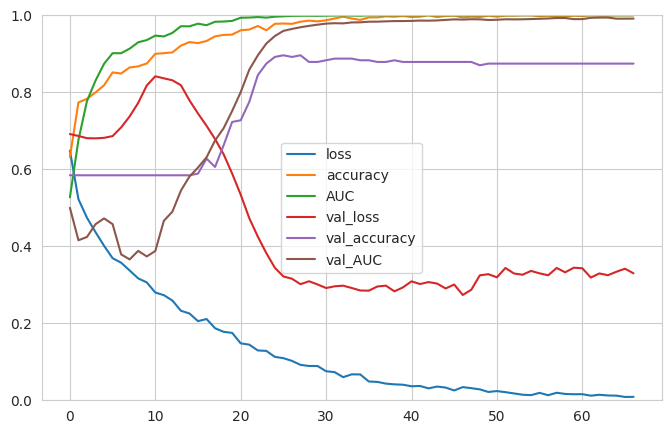

In [ ]:
import pandas as pd

pd.DataFrame(history_1.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
model_2 = tf.keras.Sequential([

    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224,224,3)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128,(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128,(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.GlobalAveragePooling2D(),   # 피쳐 방향으로 다 더해준다.(flatten 했을 경우 데이터가 너무 많아 오버피팅 되는 것을 방지)
    layers.Flatten(),

    layers.Dense(4069, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(4069, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(1, activation='sigmoid')
])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 batch_normalization_13 (Bat  (None, 222, 222, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_14 (Conv2D)          (None, 220, 220, 64)      36928     
                                                                 
 batch_normalization_14 (Bat  (None, 220, 220, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                      

In [ ]:
# 모델 컴파일
lr = 0.0000001
model_2.compile(optimizer=tf.keras.optimizers.Adam(lr),
                loss='binary_crossentropy',
                metrics=['accuracy', AUC(name='AUC')])

# 모델 학습
from tensorflow.python.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="min")

history_2 = model_2.fit(X_train, y_train, epochs=150, batch_size=32,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping])

Epoch 1/150
34/34 [==============================] - 26s 458ms/step - loss: 0.6445 - accuracy: 0.6558 - AUC: 0.4502 - val_loss: 0.6930 - val_accuracy: 0.5844 - val_AUC: 0.5000
Epoch 2/150
34/34 [==============================] - 15s 442ms/step - loss: 0.6232 - accuracy: 0.7032 - AUC: 0.4680 - val_loss: 0.6906 - val_accuracy: 0.5844 - val_AUC: 0.4949
Epoch 3/150
34/34 [==============================] - 15s 432ms/step - loss: 0.6213 - accuracy: 0.7069 - AUC: 0.4656 - val_loss: 0.6859 - val_accuracy: 0.5844 - val_AUC: 0.5067
Epoch 4/150
34/34 [==============================] - 15s 447ms/step - loss: 0.5985 - accuracy: 0.7301 - AUC: 0.5102 - val_loss: 0.6817 - val_accuracy: 0.5844 - val_AUC: 0.4384
Epoch 5/150
34/34 [==============================] - 15s 451ms/step - loss: 0.5912 - accuracy: 0.7282 - AUC: 0.5249 - val_loss: 0.6795 - val_accuracy: 0.5844 - val_AUC: 0.4949
Epoch 6/150
34/34 [==============================] - 15s 453ms/step - loss: 0.5794 - accuracy: 0.7468 - AUC: 0.5455 - va

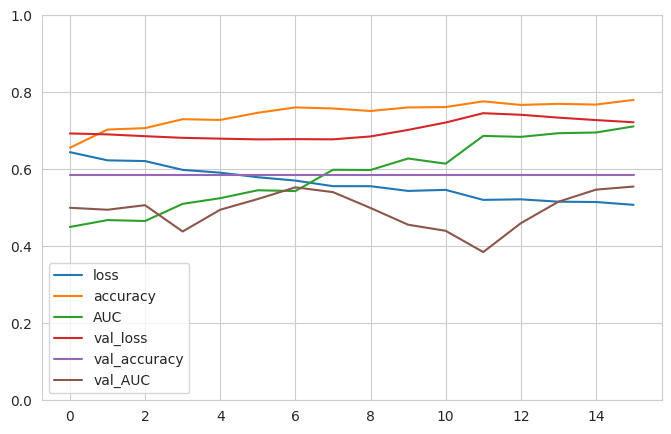

In [ ]:
import pandas as pd

pd.DataFrame(history_2.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
y_pred_2 = model_2.predict(X_test)
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_pred_2)
roc_auc_2 = auc(fpr_2, tpr_2)
print('AUROC: ', roc_auc_2)

8/8 [==============================] - 1s 118ms/step
AUROC:  0.5563271604938271


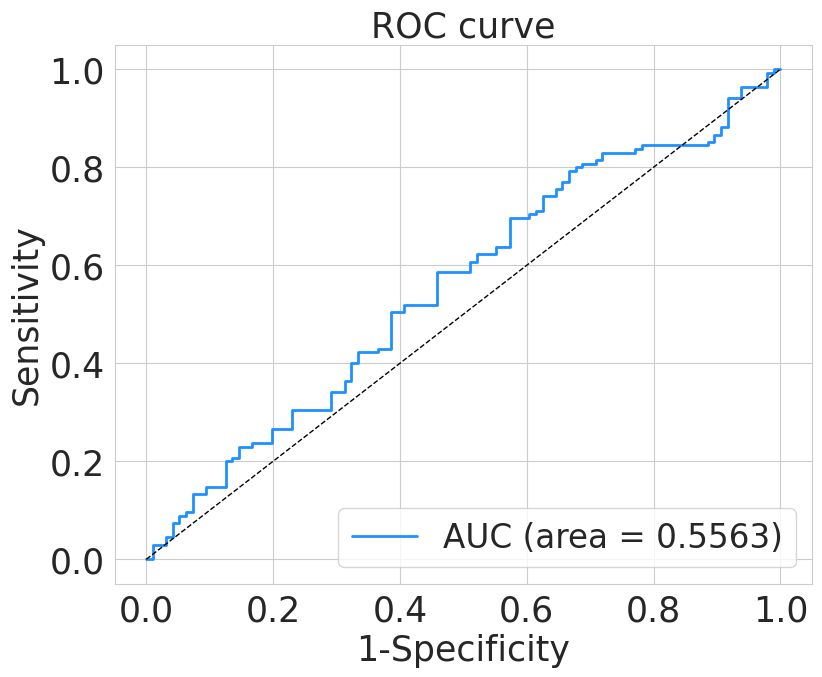

In [ ]:
plt.figure(figsize=[9,7])
plt.plot(fpr_2, tpr_2, color='dodgerblue', lw=2, label='AUC (area = %0.4f)' % roc_auc_2)
plt.plot([0,1], [0,1], color='black', lw=1, linestyle='--')
plt.xlim([-.05, 1.05])
plt.ylim([-.05, 1.05])
plt.xlabel('1-Specificity', fontsize=25)  # FPR
plt.ylabel('Sensitivity', fontsize=25)
plt.title('ROC curve', fontsize=25)
plt.legend(loc='lower right', fontsize=23.5)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

In [ ]:
model_3 = tf.keras.Sequential([

    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224,224,3)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128,(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128,(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.GlobalAveragePooling2D(),   # 피쳐 방향으로 다 더해준다.(flatten 했을 경우 데이터가 너무 많아 오버피팅 되는 것을 방지)
    layers.Flatten(),

    layers.Dense(4069, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(4069, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(1, activation='sigmoid')
])

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 batch_normalization_26 (Bat  (None, 222, 222, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_27 (Conv2D)          (None, 220, 220, 64)      36928     
                                                                 
 batch_normalization_27 (Bat  (None, 220, 220, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                      

In [ ]:
# 모델 컴파일
lr = 0.0000005
model_3.compile(optimizer=tf.keras.optimizers.Adam(lr),
                loss='binary_crossentropy',
                metrics=['accuracy', AUC(name='AUC')])

# 모델 학습
from tensorflow.python.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="min")

history_3 = model_3.fit(X_train, y_train, epochs=150, batch_size=32,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping])

Epoch 1/150
34/34 [==============================] - 25s 448ms/step - loss: 0.5329 - accuracy: 0.7727 - AUC: 0.6821 - val_loss: 0.6818 - val_accuracy: 0.5844 - val_AUC: 0.5111
Epoch 2/150
34/34 [==============================] - 15s 432ms/step - loss: 0.4992 - accuracy: 0.7829 - AUC: 0.7311 - val_loss: 0.6795 - val_accuracy: 0.5844 - val_AUC: 0.4914
Epoch 3/150
34/34 [==============================] - 15s 434ms/step - loss: 0.4648 - accuracy: 0.7885 - AUC: 0.8089 - val_loss: 0.6789 - val_accuracy: 0.5844 - val_AUC: 0.4924
Epoch 4/150
34/34 [==============================] - 15s 450ms/step - loss: 0.4541 - accuracy: 0.7922 - AUC: 0.8131 - val_loss: 0.6799 - val_accuracy: 0.5844 - val_AUC: 0.4860
Epoch 5/150
34/34 [==============================] - 15s 453ms/step - loss: 0.4121 - accuracy: 0.8117 - AUC: 0.8796 - val_loss: 0.6849 - val_accuracy: 0.5844 - val_AUC: 0.5145
Epoch 6/150
34/34 [==============================] - 15s 442ms/step - loss: 0.3987 - accuracy: 0.8312 - AUC: 0.8812 - va

In [ ]:
import pandas as pd

pd.DataFrame(history_3.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
y_pred_2 = model_2.predict(X_test)
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_pred_2)
roc_auc_2 = auc(fpr_2, tpr_2)
print('AUROC: ', roc_auc_2)